In [1]:
require 'torch'
require 'nn'
require 'image'
require 'optim'

In [26]:
loadcaffe_wrap = require 'loadcaffe_wrapper'
json = require 'json'

In [2]:
cmd = torch.CmdLine()

-- Basic options
cmd:option('-style_image', 'in/style.jpg',
           'Style target image')
cmd:option('-style_blend_weights', 'nil')
cmd:option('-content_image', 'in/content.jpg',
           'Content target image')
cmd:option('-image_size', 512, 'Maximum height / width of generated image')
cmd:option('-gpu', -1, 'Zero-indexed ID of the GPU to use; for CPU mode set -gpu = -1')

-- Optimization options
cmd:option('-content_weight', 5e0)
cmd:option('-style_weight', 1e2)
cmd:option('-tv_weight', 1e-3)
cmd:option('-num_iterations', 1000)
cmd:option('-normalize_gradients', false)
cmd:option('-init', 'random', 'random|image')
cmd:option('-optimizer', 'lbfgs', 'lbfgs|adam')
cmd:option('-learning_rate', 1e1)

-- Output options
cmd:option('-print_iter', 50)
cmd:option('-save_iter', 100)
cmd:option('-output_image', 'out.png')

-- Other options
cmd:option('-style_scale', 1.0)
cmd:option('-pooling', 'max', 'max|avg')
cmd:option('-proto_file', 'models/VGG_ILSVRC_19_layers_deploy.prototxt')
cmd:option('-model_file', 'models/VGG_ILSVRC_19_layers.caffemodel')
cmd:option('-backend', 'nn', 'nn|cudnn')
cmd:option('-seed', -1)

cmd:option('-content_layers', 'relu4_2', 'layers for content')
cmd:option('-style_layers', 'relu1_1,relu2_1,relu3_1,relu4_1,relu5_1', 'layers for style')

local arg = {} -- when running from cli, this should be defined

params = cmd:parse(arg)
print(params)

{
  style_weight : 100
  pooling : max
  seed : -1
  content_image : in/content.jpg
  save_iter : 100
  style_scale : 1
  style_image : in/style.jpg
  optimizer : lbfgs
  style_blend_weights : nil
  init : random
  gpu : -1
  content_layers : relu4_2
  model_file : models/VGG_ILSVRC_19_layers.caffemodel
  print_iter : 50
  proto_file : models/VGG_ILSVRC_19_layers_deploy.prototxt
  output_image : out.png
  image_size : 512
  normalize_gradients : false
  num_iterations : 1000
  learning_rate : 10
  style_layers : relu1_1,relu2_1,relu3_1,relu4_1,relu5_1
  content_weight : 5
  backend : nn
  tv_weight : 0.001
}


In [3]:
-- load caffe network image
cnn = loadcaffe_wrap.load(params.proto_file, params.model_file, params.backend):float()

if params.gpu >= 0 then
    cnn:cuda()
end

Successfully loaded models/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3


conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


In [4]:
-- Preprocess an image before passing it to a Caffe model.
-- We need to rescale from [0, 1] to [0, 255], convert from RGB to BGR,
-- and subtract the mean pixel.
function preprocess(img)
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
  local perm = torch.LongTensor{3, 2, 1}
  img = img:index(1, perm):mul(256.0)
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
  img:add(-1, mean_pixel)
  return img
end

-- Undo the above preprocessing.
function deprocess(img)
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
  img = img + mean_pixel
  local perm = torch.LongTensor{3, 2, 1}
  img = img:index(1, perm):div(256.0)
  return img
end

In [18]:
-- Returns a network that computes the CxC Gram matrix from inputs
-- of size C x H x W – straight from jcjohnson
function GramMatrix()
    local net = nn.Sequential()
    net:add(nn.View(-1):setNumInputDims(2))
    local concat = nn.ConcatTable()
    concat:add(nn.Identity())
    concat:add(nn.Identity())
    net:add(concat)
    net:add(nn.MM(false, true))
    return net
end

In [43]:
function SaveTable(table, filename, dir)
    filename = filename or "out"
    dir = dir or 'out/'
    string = json.encode(table)
    f = assert(io.open(dir .. filename .. '.json', "w"))
    f:write(string)
    f:close()
end

-- SaveTable(style_layers)

function LoadTable(filename, dir)
    dir = dir or 'out/'
    f = assert(io.open(dir .. filename .. '.json', "r"))
    return json.decode(f:read())
end

-- print(LoadTable('out.json'))

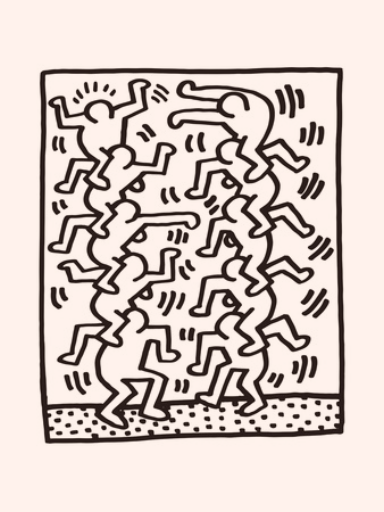

In [7]:
--load and preprocess content image
local content_image = image.load(params.content_image, 3)
content_image = image.scale(content_image, params.image_size, 'bilinear')
content_image_caffe = preprocess(content_image):float()

itorch.image(content_image_caffe)

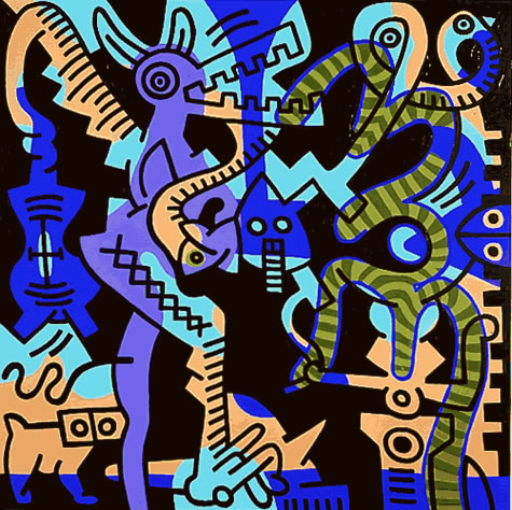

In [13]:
--load and preprocess style images

--deals with lots of input – mainly runs the same as our content image
local style_size = math.ceil(params.style_scale * params.image_size)
local style_image_list = params.style_image:split(',')

style_images_caffe = {}
for _, img_path in ipairs(style_image_list) do
    local img = image.load(img_path, 3)
    img = image.scale(img, style_size, 'bilinear')
    local img_caffe = preprocess(img):float()
    table.insert(style_images_caffe, img_caffe)    
end

itorch.image(style_images_caffe[1])

In [14]:
-- we now have style_images_caffe (table) and content_image_caffe

-- I think this just turns on a cuda() flag?
if params.gpu >= 0 then
    content_image_caffe = content_image_caffe:cuda()
    for i = 1, #style_images_caffe do
      style_images_caffe[i] = style_images_caffe[i]:cuda()
    end
end

In [15]:
--
content_layers = params.content_layers:split(',')
style_layers = params.style_layers:split(',')
print('content:', content_layers)
print('style:\t', style_layers)

content:	{
  1 : relu4_2
}
style:		{
  1 : relu1_1
  2 : relu2_1
  3 : relu3_1
  4 : relu4_1
  5 : relu5_1
}


In [44]:
-- Set up the network, inserting style and content loss modules
content_losses, style_losses = {}, {}
next_content_idx, next_style_idx = 1, 1

net = nn.Sequential()

-- print(net)
-- print(cnn)


for i = 1, #cnn do
    
    if next_content_idx <= #content_layers or next_style_idx <= #style_layers then
        local layer = cnn:get(i)
        local layer_name = layer.name
        local layer_type = torch.type(layer)
        local is_pooling = (layer_type == 'cudnn.SpatialMaxPooling' or layer_type == 'nn.SpatialMaxPooling')

--         print(i, layer_name, layer_type, is_pooling)

        -- adding each layer to net
        if is_pooling and params.pooling == 'avg' then    -- change from max- to avg-pooling
            assert(layer.padW == 0 and layer.padH == 0)
            -- kWxkH regions by step size dWxdH
            local kW, kH = layer.kW, layer.kH
            local dW, dH = layer.dW, layer.dH
            local avg_pool_layer = nn.SpatialAveragePooling(kW, kH, dW, dH):float()
            if params.gpu >= 0 then avg_pool_layer:cuda() end
            local msg = 'Replacing max pooling at layer %d with average pooling'
            print(string.format(msg, i))
            net:add(avg_pool_layer)
        else
            net:add(layer)
        end

        -- skipping content layers
        
        -- now to grab style layers
        if (layer_name == style_layers[next_style_idx]) then
            print("Setting up style layer ", i, ":", layer_name)
            
            local gram = GramMatrix():float()
            if params.gpu >= 0 then gram = gram:cuda() end
            
            local target = nil
            
            for i = 1, #style_images_caffe do
                
                local target_features = net:forward(style_images_caffe[i]):clone()
                
                SaveTable(target_features, 'target_features_' .. layer_name)
                
                local target_i = gram:forward(target_features):clone()
                
                SaveTable(target_i, 'target_i_' .. layer_name)
                
--                 target_i:div(target_features:nElement())
--                 target_i:mul(style_blend_weights[i])
                
--                 if i == 1 then
--                     target = target_i
--                 else
--                     target:add(target_i)
--                 end            
            end
            
--             local norm = params.normalize_gradients
--             local loss_module = nn.StyleLoss(params.style_weight, target, norm):float()
--             if params.gpu >= 0 then
--                 loss_module:cuda()
--             end
            
--             net:add(loss_module)
--             table.insert(style_losses, loss_module)
            next_style_idx = next_style_idx + 1
            
        end
    end
end

Setting up style layer 	2	:	relu1_1	


not enough memory: 

{
  1 : relu1_1
  2 : relu2_1
  3 : relu3_1
  4 : relu4_1
  5 : relu5_1
}
52	
